# Modeling

In [1]:
from sklearn import metrics
import catboost as cat
from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error as mae, r2_score as r2
from scipy.stats import uniform, randint

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")


def mae(y_gt, Y_pr):
    return metrics.mean_absolute_error(y_gt, Y_pr)

def mse(y_gt, Y_pr):
    return metrics.mean_squared_error(y_gt, Y_pr)

def rmse(y_gt, Y_pr):
    my_mse = mse(y_gt, Y_pr)
    return np.sqrt(my_mse)

def medae(y_gt, Y_pr):
    return metrics.median_absolute_error(y_gt, Y_pr)

def R2(y_gt, Y_pr):
    return metrics.r2_score(y_gt, Y_pr)

def calc_metrics(y_test, y_pred, X):
    
    y_test = target_transformer.inverse_transform(y_test)
    y_pred = target_transformer.inverse_transform(pd.Series(y_pred))

    mse1 = mse(y_test, y_pred)

    rmse1 = rmse(y_test, y_pred)

    mae1 = mae(y_test, y_pred)

    medae1 = medae(y_test, y_pred)

    R21 = R2(y_test, y_pred)
    
    adj_r2 = 1 - (1-r2(y_test, y_pred)) * (len(y)-1)/(len(y)-X.shape[1]-1)

    print('*** VAL **: ')
    print("MSE:   {}\nRMSE:  {}\nR2:    {}\nMAE:   {}\nMedAE: {}\nAdj_R2:  {}".format(mse1, rmse1, R21, mae1, medae1, adj_r2))
    print('-'*30)


def get_importance(train_dataset, cat_model, title='Catboost feature importance', save_fig=False, file_name='cat_feature_importance.png'):
    imp = cat_model.get_feature_importance(data=train_dataset)
    fig, axes = plt.subplots(1, 1, figsize=(12, 8))
    axes.barh(width=imp, y=cat_model.feature_names_)
    axes.set_title(title)
    if save_fig:
        plt.savefig(file_name)
    plt.show()
    

def draw_target_distr(y_test, y_pred, save_fig=False, file_name='cat_distribution'):
    plt.figure(figsize=(12, 5))
    sns.distplot(y_test)
    sns.distplot(y_pred)
    plt.legend(['test', 'pred'])
    if save_fig:
        plt.savefig(file_name)
    plt.show()

    
def draw_residuals(y_test, y_pred, save_fig=False,
                   file_name='cat_residuals.png'):
    y_test = target_transformer.inverse_transform(y_test)
    y_pred = target_transformer.inverse_transform(pd.Series(y_pred))  / MULTIPLIER
    sns.residplot(x=y_test, y=y_pred)
    if save_fig:
        plt.savefig(file_name)
    plt.show()
    
    
class TargetTransformer:
    def __init__(self, denominator=1):
        self.scale = denominator
        
    def inverse_transform(self, feature):
        return feature.apply(lambda x: np.expm1(x))
    
    def transform(self, feature):
        return feature.apply(lambda x: np.log1p(x))
    
target_transformer = TargetTransformer()

In [2]:
with open('dataset_0.pkl', 'rb') as f:
    df_pr = pickle.load(f)

In [3]:
df_pr.head()

,age_access_type,average_rating,duration,type,name,release_year,target,subscription_only,actor_0,actor_1,...,actor_4,country_0,genre_0,genre_1,genre_2,director_0,RENT,AVOD,SUBSCRIPTION,DTO
0,18,4.00,15.607270,MOVIE,В поисках древнего артефакта,2019,0.000004,0,cff3362f-ad91-498d-80b3-ea3ab8ec65cf,bcad17eb-f43b-4b51-864c-d03317b392d4,...,273e8e47-f21c-4b3a-b77e-e423d75c500d,usa,Horror,Na,Na,895f5774-964a-4c5a-ae22-d697d3e3e620,1,0,1,1
1,18,6.99,15.145235,MOVIE,Прожарка Чарли Шина,2011,0.000354,1,cff3362f-ad91-498d-80b3-ea3ab8ec65cf,30dd19ca-115c-4d1a-a508-74174e866829,...,8833aec0-88dc-4e6a-b362-478020f900e9,usa,Comedy,Documentary,Na,1de22aff-430e-4af9-bf1d-159dbf8e9269,0,0,1,0
2,18,6.00,15.145235,MOVIE,Прожарка Уильяма Шэтнера,2006,0.000064,1,cff3362f-ad91-498d-80b3-ea3ab8ec65cf,a805fdd3-7415-42f0-9d00-b1a9f1a670ac,...,9bcfdaeb-ab42-4d02-b90f-cf9e72f399fe,usa,Comedy,Na,Na,1de22aff-430e-4af9-bf1d-159dbf8e9269,0,0,1,0
3,0,6.21,15.396549,MOVIE,Большое путешествие,2006,0.000003,1,cff3362f-ad91-498d-80b3-ea3ab8ec65cf,a51b3766-26a9-4064-8774-5b3b0ff3f38c,...,8bd0469c-6e4e-4fbd-ba67-3c772c8e1475,usa,Family,287a1485-7a88-4c2f-bc94-ca418b6c47a1,Na,fe598c84-ef4f-47c7-91af-d5cbd89c4e8d,0,0,1,0
4,6,6.40,15.523889,MOVIE,Пламенное сердце,2022,0.009705,1,cff3362f-ad91-498d-80b3-ea3ab8ec65cf,873fd466-9242-4413-b0f6-23812f622629,...,20269693-d9e7-41e8-bdd0-3f8195e30ad6,canada,Comedy,Adventure,Family,40f78e6d-3c9f-434f-a505-c6ffdd045763,0,0,1,0


In [4]:
df_pr = df_pr[df_pr['release_year'].astype(int) >= 2020][['age_access_type', 'duration', 'type', 'target', 'actor_0', 'actor_1',
                                                       'actor_2', 'actor_3', 'actor_4', 'country_0', 'genre_0', 'genre_1',
                                                       'genre_2', 'director_0']]

df_pr.reset_index(inplace=True, drop=True)

In [5]:
df_pr.columns

Index(['age_access_type', 'duration', 'type', 'target', 'actor_0', 'actor_1',
       'actor_2', 'actor_3', 'actor_4', 'country_0', 'genre_0', 'genre_1',
       'genre_2', 'director_0'],
      dtype='object')

In [6]:
cat_features = ['age_access_type',  'type', 'actor_0', 'actor_1',
               'actor_2', 'actor_3', 'actor_4', 'country_0', 'genre_0', 'genre_1',
               'genre_2', 'director_0']

In [7]:
df_pr[cat_features]

,age_access_type,type,actor_0,actor_1,actor_2,actor_3,actor_4,country_0,genre_0,genre_1,genre_2,director_0
0,6,MOVIE,cff3362f-ad91-498d-80b3-ea3ab8ec65cf,873fd466-9242-4413-b0f6-23812f622629,b913af79-94c1-451e-a296-d7af605aa8a8,835ee040-4619-4f51-a4b3-d15f96814793,20269693-d9e7-41e8-bdd0-3f8195e30ad6,canada,Comedy,Adventure,Family,40f78e6d-3c9f-434f-a505-c6ffdd045763
1,16,MOVIE,cff3362f-ad91-498d-80b3-ea3ab8ec65cf,39124be7-4ee9-4d9e-9ff5-1af5e4f689f8,736b6339-8041-4d85-97ae-d432a7a5ee1e,d397d645-a75d-45f8-b531-acc65cba07bd,3d9a487a-0987-47ad-a91c-366b9a354843,usa,Comedy,Melodrama,Drama,f5fba6fe-94b3-4e69-acfc-da6867320386
2,16,MOVIE,8b115bc4-aa53-4c9d-92ce-a99433da0dfe,48ac7c63-1f36-495f-acb7-31313f6208cb,22afaabe-6f05-4f6a-bbdc-cf1f2424d8df,5a9287c3-44c9-48de-9a2c-f27edb5e6cb9,018490c7-570d-4176-8240-bba7251a3d74,great-britain,0ef0aa70-f86c-4141-8054-8b39af97867d,Na,Na,e6d2ec4a-fefc-4413-9143-bbef2c281810
3,16,MOVIE,6bbf91d5-e892-44c9-9d6d-e3c4dd72ad10,e4b06d92-a03f-4489-abfc-738013e01782,e2c6e522-8d0b-4aed-96c6-bbbf54e35be9,0890d17c-d4c0-4289-88a5-b4b1640d45ae,30b01d30-61cc-4eb9-9a60-c0e5941598a3,great-britain,Sci-Fi,Thriller,Na,f96887a1-24ed-4f7a-95c9-41f3832c67ab
4,18,MOVIE,110a45b4-462e-416b-8d07-f1a275b95a3b,bb4c88a2-5d07-4da5-badf-9e2e15976a74,3502cd30-978a-4067-ab05-bc8c5c5ceb7d,f95fd73f-1eda-427a-b08f-88e6fa1962a5,771b32bb-32dc-4ffb-a431-75a9853a7fc0,germany,Drama,Na,Na,122b2b2e-6418-4dbc-86ba-af1e77a514ee
...,...,...,...,...,...,...,...,...,...,...,...,...
1458,18,SERIAL,558ca4e5-0fe8-4a38-9519-d3c7fc134c0a,22690330-dbcc-4ca8-a51f-720962725916,e589f27d-eaf8-4889-b20b-aab884826621,f7c780c5-bcec-4624-a862-c285a0c39408,bf24bdfb-0713-4f7f-813a-00a586f69697,usa,Comedy,Music,Na,b88c3216-5b55-495b-9838-ed03a6b46002
1459,18,SERIAL,ad87ebda-05b5-4662-b88a-07e123364ee1,fd583cc9-6e05-40fd-83ae-cd205dbc058f,aaa53285-1b01-4dc6-af56-f14c392813e0,3a2d9132-62ab-447a-9904-b50722353835,6b4d945a-c708-4256-89b4-f3528a3bbfaf,usa,Comedy,Documentary,0ef0aa70-f86c-4141-8054-8b39af97867d,0794a525-b93d-47c0-97b8-5490acc55c95
1460,18,SERIAL,d3ac2bba-c855-40b1-98ed-5a360484846c,03968c90-4be3-46a4-96cd-a14735d689d4,9f5d2099-c7b3-41fa-9bd0-f0d1e74b5c2f,fdedc5a1-7cbf-43b4-9d44-0c243d4f3a26,349f6032-05b3-46ca-a466-b988278725f9,usa,Thriller,Melodrama,Drama,e64d4233-2574-465e-a1c3-af8fadd4f934
1461,16,SERIAL,40977851-22fb-4829-8c01-d73acaa39ffe,17cf0f03-562b-4891-b93e-b3d186ff1fc9,da1b9c83-8f33-408f-9397-835b3d5a16e5,e4e38894-6207-4eee-b5e2-303cbc51cda4,56793f54-16d5-4b77-bb76-d0840915a517,south-korea,Thriller,Detective,364fdc2e-bdfe-40be-b2c5-d30f43ec432e,3b3fbcd5-3730-482a-b0e0-dee6f9d9dc7b


In [79]:
MULTIPLIER = 100
X, y = df_pr.drop(['target'], axis=1), df_pr['target']  * MULTIPLIER
y = target_transformer.transform(y)

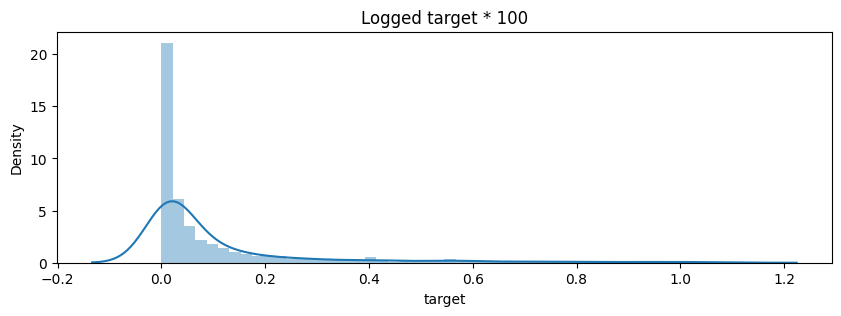

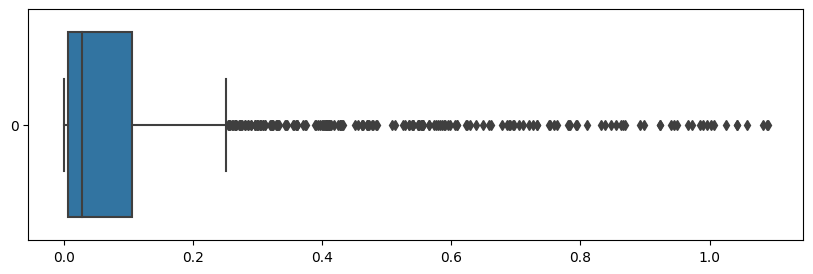

In [80]:
plt.figure(figsize=(10, 3))
sns.distplot(y)
plt.title('Logged target * 100')
plt.show()

plt.figure(figsize=(10, 3))
sns.boxplot(y.values, orient='h')
plt.show()

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=False)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.2, random_state=42, shuffle=False)
train_dataset = cat.Pool(X_train, y_train,
                         cat_features=cat_features,   
                        )
test_dataset = cat.Pool(X_test, y_test,
                         cat_features=cat_features,
                       )
val_dataset = cat.Pool(X_val, y_val,
                       cat_features=cat_features,
                      )

## Training

In [82]:
cat_params = {
    'loss_function': 'RMSE',
    'eval_metric': 'MAE',
    'verbose': True,
    'random_seed': 321,
    'allow_writing_files': False, 
    'cat_features': cat_features,
    'iterations': 10000, 
}

cat_model = cat.CatBoostRegressor(**cat_params)

cat_model.fit(
    train_dataset,
    eval_set=val_dataset,
    early_stopping_rounds=50,
    verbose=100,
    plot=False
)

cat_model.save_model('7')

Learning rate set to 0.01305
0:	learn: 0.1215033	test: 0.0780374	best: 0.0780374 (0)	total: 6.35ms	remaining: 1m 3s
100:	learn: 0.1111243	test: 0.0739683	best: 0.0733683 (82)	total: 543ms	remaining: 53.2s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.0733683249
bestIteration = 82

Shrink model to first 83 iterations.


In [83]:
# cat_model = cat.CatBoostRegressor(**cat_params)
# cat_model.load_model('3')

In [84]:
y_pred = cat_model.predict(X_test)

In [85]:
calc_metrics(y_test, y_pred, X)

*** VAL **: 
MSE:   0.10460943606047575
RMSE:  0.32343382021748396
R2:    0.09810455958166653
MAE:   0.16163241033541523
MedAE: 0.08137617453626611
Adj_R2:  0.09001302008861045
------------------------------


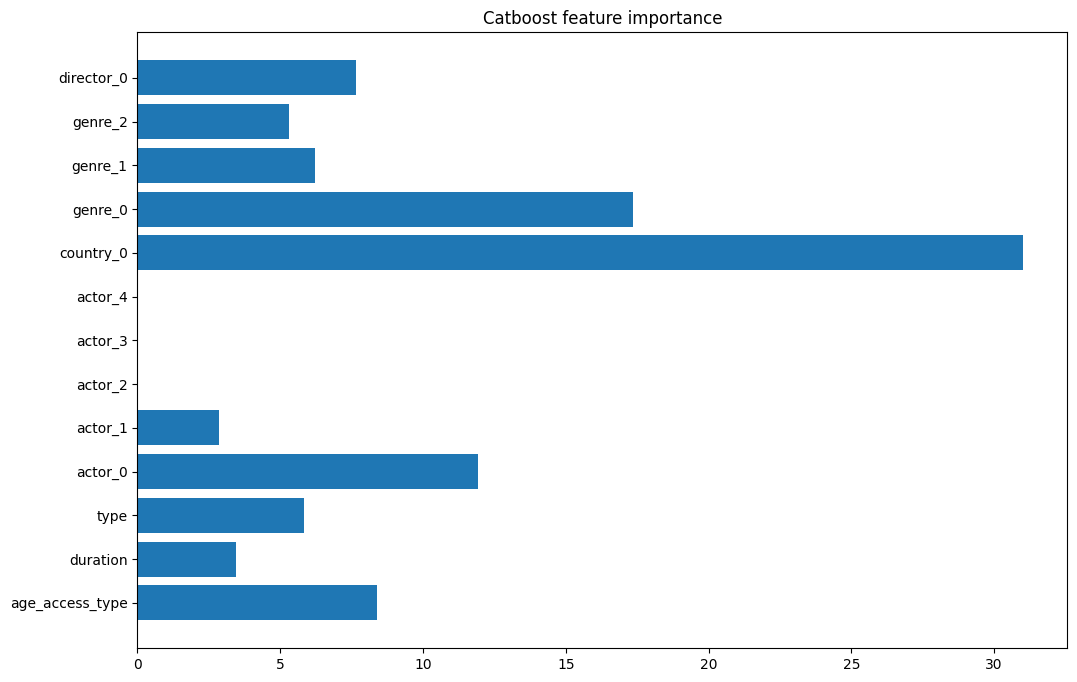

In [90]:
get_importance(train_dataset, cat_model, title='Catboost feature importance', save_fig=False, file_name='cat_feature_importance.png')

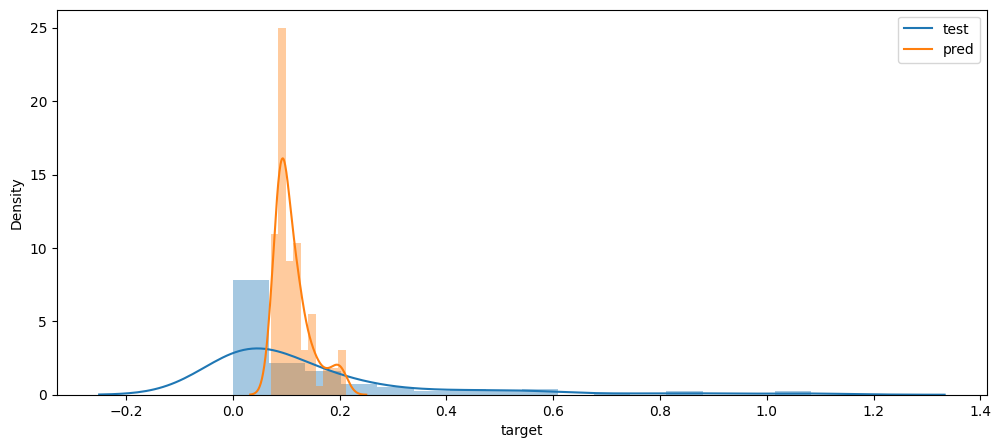

In [87]:
draw_target_distr(y_test, y_pred, save_fig=False, file_name='cat_distribution')

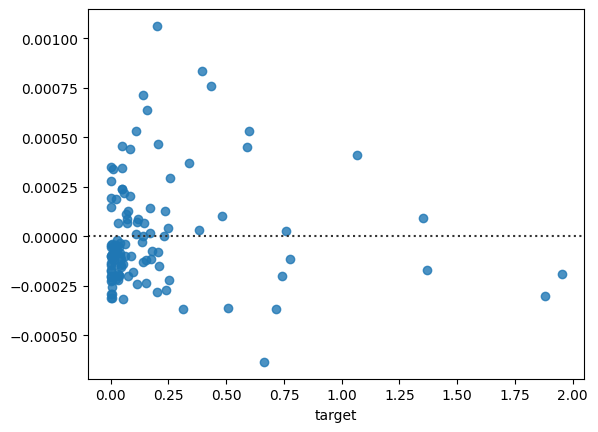

In [88]:
draw_residuals(y_test, y_pred, save_fig=False)

In [89]:
len(y_pred[y_pred <= 0])

0